In [1]:
import pandas as pd
from datetime import datetime, timedelta, date
import numpy as np
from collections import Counter
from data_science_toolkit.data_visualization import get_fig_ax, visualize_class_distribution, top_n_tokens_plot_from_counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize 
# Stealing stuff... http://brandonrose.org/clustering
from nltk.stem.snowball import SnowballStemmer
import nltk, re
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora, models, similarities 
from data_science_toolkit.association_rules import apriori_with_df
from data_science_toolkit.data_visualization import generate_histogram

In [2]:
output_col = 'above_monthly_avg'
file_name = 'trump_tweets_sp500.csv'
# file_name = 'elonmusk_twint_preprocessed.csv'

In [3]:
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)

In [4]:
stop_words = set(stopwords.words('english')).union({'', 'would'})
# , '-', '&', '"', ':', '/'
stemmer = SnowballStemmer("english")

In [5]:
stock_tweet = pd.read_csv('./stocks/{}'.format(file_name))
stock_tweet['created_at']= pd.to_datetime(stock_tweet['created_at']) 

In [6]:
stock_tweet.head(2)

,text,retweet_count,retweet,num_videos,created_at,preprocessed_text,created_hour,dow,num_links,num_words,num_photos,above_monthly_avg,percent_caps,num_hashtags,num_mentions
0,"The Club For Growth,which asked me for $1,000,000 in an extortion attempt, just put up a Wisconsin ad with incorrect math.What a dumb group!",4791.0,False,0.0,2016-04-01 00:23:25,"the club for growth , which asked me for $ 1,000,000 in an extortion attempt , just put up a wisconsin ad with incorrect math.what a dumb group !",0,4,0,0.16,0,1,0.0,0,0
1,The Club For Growth said in their ad that 465 delegates (Cruz) plus 143 delegates (Kasich) is more than my 739 delegates. Try again!,4434.0,False,0.0,2016-04-01 00:29:49,the club for growth said in their ad that 465 delegates ( cruz ) plus 143 delegates ( kasich ) is more than my 739 delegates . try again !,0,4,0,0.17,0,1,0.0,0,0


In [7]:
# since_election = stock_tweet[stock_tweet["created_at"] > datetime(2016, 11, 8)]

In [8]:
prep_all_tweets = stock_tweet["preprocessed_text"].tolist()
# prep_tweets_since_election = stock_tweet["preprocessed_text"].tolist()

# 1.0 Class Distribution

Exception in get_axis 'AxesSubplot' object has no attribute 'any'


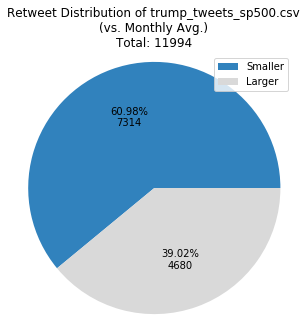

In [9]:
fig, ax = get_fig_ax(1, 1, 5, 5)
ax = visualize_class_distribution(stock_tweet[output_col], 
                                  given_title="Retweet Distribution of {}\n(vs. Monthly Avg.)".format(file_name), 
                                  given_label_titles={1: "Larger", 0:"Smaller"}, axes=ax, row_idx=0, col_idx=0)

## 1.1 Class Distribution since Election

In [10]:
# fig, ax = get_fig_ax(1, 1, 5, 5)
# ax = visualize_class_distribution(stock_tweet[output_col], 
#                                   given_title="Retweet Distribution Since Election of {}\n(vs. Monthly Avg.)".format(file_name), 
#                                   given_label_titles={1: "Larger", 0:"Smaller"}, axes=ax, row_idx=0, col_idx=0)

# 2.0 Most Common Words

In [11]:
def filtered_word_array(tweet, words_to_ignore={}):
    return [x for x in tweet.split(' ') if x not in stop_words.union(words_to_ignore) and re.search('[a-zA-Z]', x)]

In [12]:
stock_tweet.iloc[3500]

text                 The era of strategic patience with the North Korea regime has failed. That patience is over. We are working closely with.... pic.twitter.com/nCZ51HnIdx
retweet_count        15124                                                                                                                                                  
retweet              False                                                                                                                                                  
num_videos           1                                                                                                                                                      
created_at           2017-06-30 16:55:44                                                                                                                                    
preprocessed_text    the era of strategic patience with the north korea regime has failed . that patience is over . we are working clos

Exception in get_axis 'AxesSubplot' object has no attribute 'any'


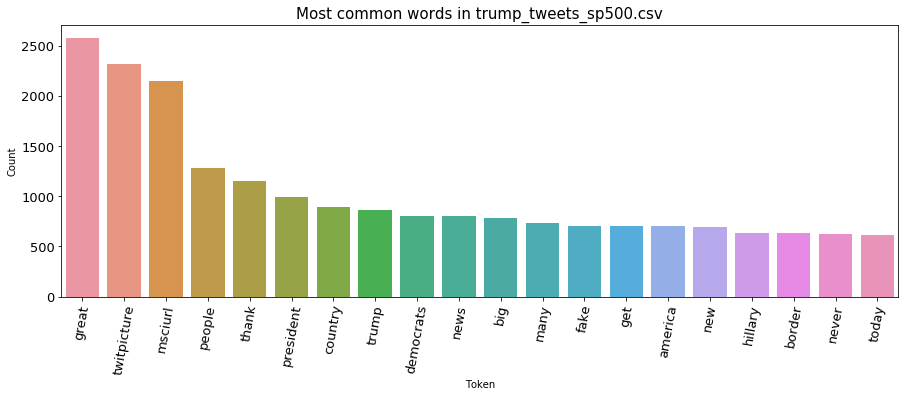

In [14]:
fig, ax = get_fig_ax(1, 1, 15, 5)
ax = top_n_tokens_plot_from_counter(Counter([x for x in filtered_word_array(' '.join(prep_all_tweets))]), 
                                    20, ax, 0, 0, "Most common words in {}".format(file_name))

## 2.1 Most Common Words (Larger vs Smaller than monthly average)

In [15]:
above_avg = stock_tweet[stock_tweet[output_col] == 1]
above_avg_since_election = stock_tweet[stock_tweet[output_col] == 1]
below_avg = stock_tweet[stock_tweet[output_col] == 0]
below_avg_stock_tweet = stock_tweet[stock_tweet[output_col] == 0]

In [16]:
def get_count_no_sw(df):
    return Counter(filtered_word_array(' '.join(df['preprocessed_text'].tolist())))

In [17]:
above_not_below = get_count_no_sw(above_avg) - get_count_no_sw(below_avg)
below_not_above = get_count_no_sw(below_avg) - get_count_no_sw(above_avg)

Exception in get_axis 'AxesSubplot' object has no attribute 'any'


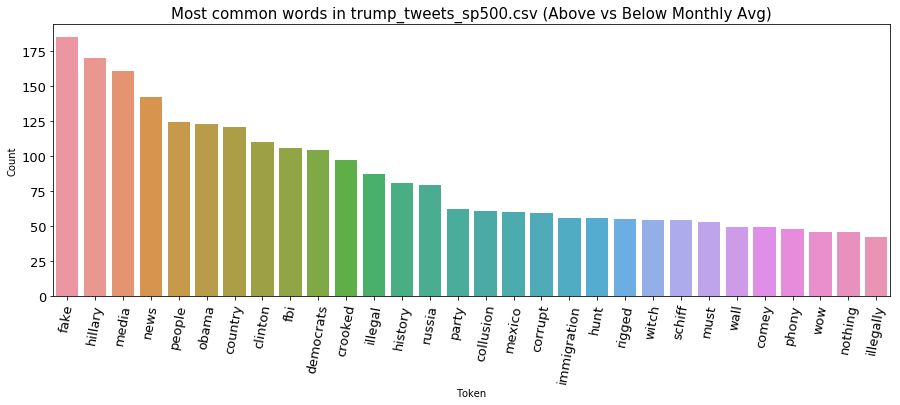

In [18]:
fig, ax = get_fig_ax(1, 1, 15, 5)
ax = top_n_tokens_plot_from_counter(above_not_below, 30, ax, 0, 0, 
                                    "Most common words in {} (Above vs Below Monthly Avg)".format(file_name))

Exception in get_axis 'AxesSubplot' object has no attribute 'any'


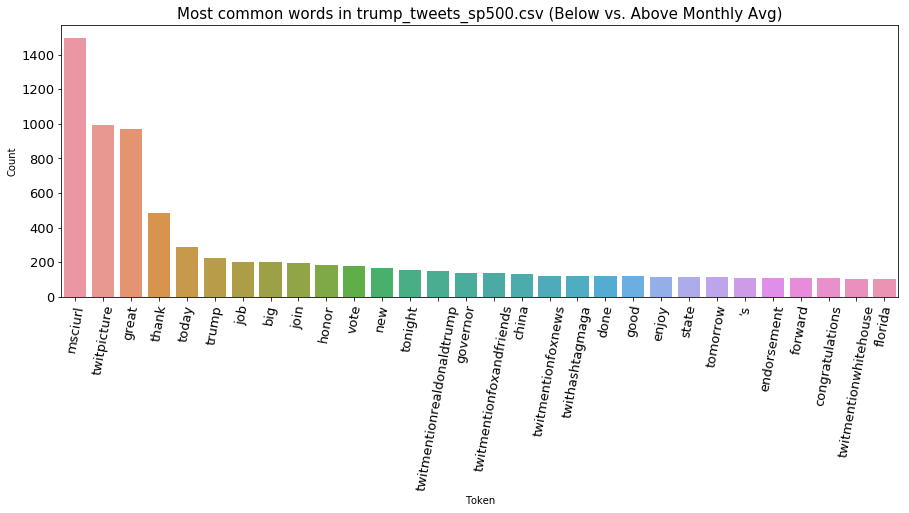

In [19]:
fig, ax = get_fig_ax(1, 1, 15, 5)
ax = top_n_tokens_plot_from_counter(below_not_above, 30, ax, 0, 0, 
                                    "Most common words in {} (Below vs. Above Monthly Avg)".format(file_name))

# K-Means Clustering for Common Topics

Summarize this but don't need to say much else

Ran out of memory trying to do this for all Trump tweets - I'm only going to do it for tweets since the election.  
Elbow method: https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f

# 3.0 Apriori - Featuresets
- Due to the small number of tweets, etc, we need to use a relatively low support of 0.02 before starting to look for rules

In [20]:
def prep_fn(text):
    text = text.split(" ")
    final = []
    for word in text:
        if re.search('[a-zA-Z]', word) and word not in stop_words:
            final.append(word)
    return final

In [21]:
frequent_itemsets = apriori_with_df(prep_all_tweets, prep_fn, min_support=0.02, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.027681,('s)
1,0.023845,(also)
2,0.055278,(america)
3,0.034517,(american)
4,0.036602,(back)
5,0.034934,(bad)
6,0.020093,(better)
7,0.061114,(big)
8,0.043772,(border)
9,0.020010,(campaign)


## Using these frequent itemsets, we can come up with association rules:

In [22]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(witch),(hunt),0.024596,0.024596,0.024262,0.986441,40.106337,0.023657,71.936072
1,(hunt),(witch),0.024596,0.024596,0.024262,0.986441,40.106337,0.023657,71.936072
2,(fake),(news),0.054944,0.062114,0.046523,0.846737,13.631905,0.043110,6.119471
3,(news),(fake),0.062114,0.054944,0.046523,0.748993,13.631905,0.043110,3.765062
4,(crooked),(hillary),0.032850,0.051109,0.028097,0.855330,16.735444,0.026418,6.559002
5,(united),(states),0.036768,0.036018,0.030682,0.834467,23.168052,0.029358,5.823508
6,(states),(united),0.036018,0.036768,0.030682,0.851852,23.168052,0.029358,6.501813


## We can use these itemsets as inputs to our SVM

# WILL NEED TO MOVE THIS INTO THE CROSS VALIDATION PIPELINE!!!

In [23]:
above_avg_apr = apriori_with_df(stock_tweet[stock_tweet[output_col] == 1]['preprocessed_text'].tolist(), prep_fn).values.tolist()
above_avg_apr_dict = {x[1]: x[0] for x in above_avg_apr if len(x[1]) > 1}
above_avg_apr_set = set([x[1] for x in above_avg_apr])

In [24]:
below_avg_apr = apriori_with_df(stock_tweet[stock_tweet[output_col] == 0]['preprocessed_text'], prep_fn).values.tolist()
below_avg_apr_dict = {x[1]: x[0] for x in below_avg_apr if len(x[1]) > 1}
below_avg_apr_set = set([x[1] for x in below_avg_apr])

In [25]:
below_avg_apr_dict

{frozenset({'msciurl', 'thank'}): 0.04552912223133716,
 frozenset({'america', 'twitpicture'}): 0.020371889526934646,
 frozenset({'great', 'thank'}): 0.030352748154224774,
 frozenset({'great', 'job'}): 0.02543068088597211,
 frozenset({'today', 'twitpicture'}): 0.02693464588460487,
 frozenset({'fake', 'news'}): 0.029258955427946404,
 frozenset({'thank', 'twitpicture'}): 0.04826360404703309,
 frozenset({'msciurl', 'twitpicture'}): 0.0701394585726005,
 frozenset({'america', 'great'}): 0.025977577249111292,
 frozenset({'great', 'people'}): 0.02392671588733935,
 frozenset({'great', 'twitpicture'}): 0.04552912223133716,
 frozenset({'honor', 'twitpicture'}): 0.020782061799289035,
 frozenset({'join', 'msciurl'}): 0.025977577249111292,
 frozenset({'great', 'msciurl'}): 0.04115395132622368,
 frozenset({'great', 'today'}): 0.0220125786163522,
 frozenset({'great', 'make'}): 0.021192234071643425,
 frozenset({'states', 'united'}): 0.02378999179655455}

In [26]:
above_avg_apr_diff = Counter(above_avg_apr_dict) - Counter(below_avg_apr_dict)

In [27]:
below_avg_apr_diff = Counter(below_avg_apr_dict) - Counter(above_avg_apr_dict)

In [28]:
below_avg_apr_diff.items()

dict_items([(frozenset({'msciurl', 'thank'}), 0.04552912223133716), (frozenset({'twitpicture', 'america'}), 0.020371889526934646), (frozenset({'thank', 'great'}), 0.030352748154224774), (frozenset({'job', 'great'}), 0.02543068088597211), (frozenset({'twitpicture', 'today'}), 0.02693464588460487), (frozenset({'twitpicture', 'thank'}), 0.01621232199575104), (frozenset({'msciurl', 'twitpicture'}), 0.0701394585726005), (frozenset({'twitpicture', 'great'}), 0.02330690000911494), (frozenset({'honor', 'twitpicture'}), 0.020782061799289035), (frozenset({'join', 'msciurl'}), 0.025977577249111292), (frozenset({'msciurl', 'great'}), 0.04115395132622368), (frozenset({'today', 'great'}), 0.0220125786163522)])

In [29]:
above_avg_apr_feats = sorted([x for x in above_avg_apr_diff.most_common(4) if x[1] > 0.04], key=lambda x: x[1], reverse=True)
below_avg_apr_feats = sorted([x for x in below_avg_apr_diff.most_common(4) if x[1] > 0.04], key=lambda x: x[1], reverse=True)

In [30]:
above_avg_apr_feats

[(frozenset({'crooked', 'hillary'}), 0.04487179487179487),
 (frozenset({'fake', 'news'}), 0.0442453180763271)]

In [31]:
# feat = above_avg_apr_feats[0]

In [32]:
def contains_feature(tweets, feat):
    contains_feat_list = []
    for tweet in tweets:
        curr_set = [1 if word in set(tweet) else 0 for word in feat]
#         print(feat, curr_set)
#         print(ting)
        contains_feat_list.append(min(curr_set))
    return contains_feat_list

In [33]:
tweets = list(map(lambda x: x.split(" "), prep_all_tweets))

In [34]:
for feat in above_avg_apr_feats:
    col_name = "above_avg_apr_{}".format('_'.join(feat[0]))
    stock_tweet[col_name] = contains_feature(tweets, feat[0])
    stock_tweet[col_name] = stock_tweet[col_name].astype('category')

In [35]:
for feat in below_avg_apr_feats:
    col_name = "below_avg_apr_{}".format('_'.join(feat[0]))
    stock_tweet[col_name] = contains_feature(tweets, feat[0])
    stock_tweet[col_name] = stock_tweet[col_name].astype('category')

In [36]:
# since_election.columns

### 3.something Kmeans
- https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e

In [37]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [38]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(list(map(lambda x: x.split(" "), prep_all_tweets)))]
model = Doc2Vec(documents, vector_size=300, window=2, min_count=1, workers=4)

In [39]:
model.train(documents, total_examples=model.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016)

In [40]:
model.docvecs.doctag_syn0

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  """Entry point for launching an IPython kernel.


array([[-4.7544312e-02,  2.3892619e-02,  2.8491354e-02, ...,
         1.4631854e-02,  4.8977017e-02, -1.0213881e-01],
       [-2.7446046e-02,  1.1791260e-02,  1.0154014e-02, ...,
         6.2348042e-03,  2.0839723e-02, -5.4747809e-02],
       [-2.5931258e-02, -9.0772635e-04,  8.7915827e-03, ...,
         5.9431135e-03,  2.2956893e-02, -4.5340098e-02],
       ...,
       [-9.4193760e-03,  2.7760677e-03,  7.8389276e-04, ...,
         1.2632347e-06,  1.3375341e-02, -1.9113760e-02],
       [-4.5338543e-03,  2.5824700e-03,  4.5309367e-04, ...,
         8.0206728e-04,  1.0522625e-02, -1.6288660e-02],
       [-8.6155897e-03,  3.0832917e-03,  5.4078898e-03, ...,
         5.6519979e-03,  4.1504395e-03, -1.8909067e-02]], dtype=float32)

In [41]:
from sklearn.externals import joblib
from sklearn.cluster import KMeans
def kmeans(num_clusters, term_matrix):
    km = KMeans(n_clusters=num_clusters, max_iter=1000000, n_jobs=6, n_init=30)
    labels = km.fit_predict(term_matrix)
#     centroids = km.cluster_centers_
    return km, labels, km.inertia_

/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [42]:
def tokenize_only(tweet):
    return [x for x in tweet.split(" ") if re.search('[a-zA-Z]', x) and x not in stop_words.union({'msciurl', 'twitpicture', "'s'"})]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  after removing the cwd from sys.path.


Iter: 2 , Num Iter:  12 Inertia:  895.3943717502589
Iter: 4 , Num Iter:  48 Inertia:  380.8483163872924
Iter: 8 , Num Iter:  33 Inertia:  220.75846416234498
Iter: 10 , Num Iter:  65 Inertia:  199.88427069576318
Iter: 20 , Num Iter:  90 Inertia:  162.14385865923305
Iter: 30 , Num Iter:  45 Inertia:  146.52695476925612
Iter: 40 , Num Iter:  69 Inertia:  136.1858057377774
Iter: 50 , Num Iter:  79 Inertia:  129.40039736345145
Iter: 60 , Num Iter:  83 Inertia:  123.82756266796474
Iter: 70 , Num Iter:  74 Inertia:  119.74683030536694
Iter: 80 , Num Iter:  67 Inertia:  116.10917918638415
Iter: 90 , Num Iter:  58 Inertia:  113.00889399160248


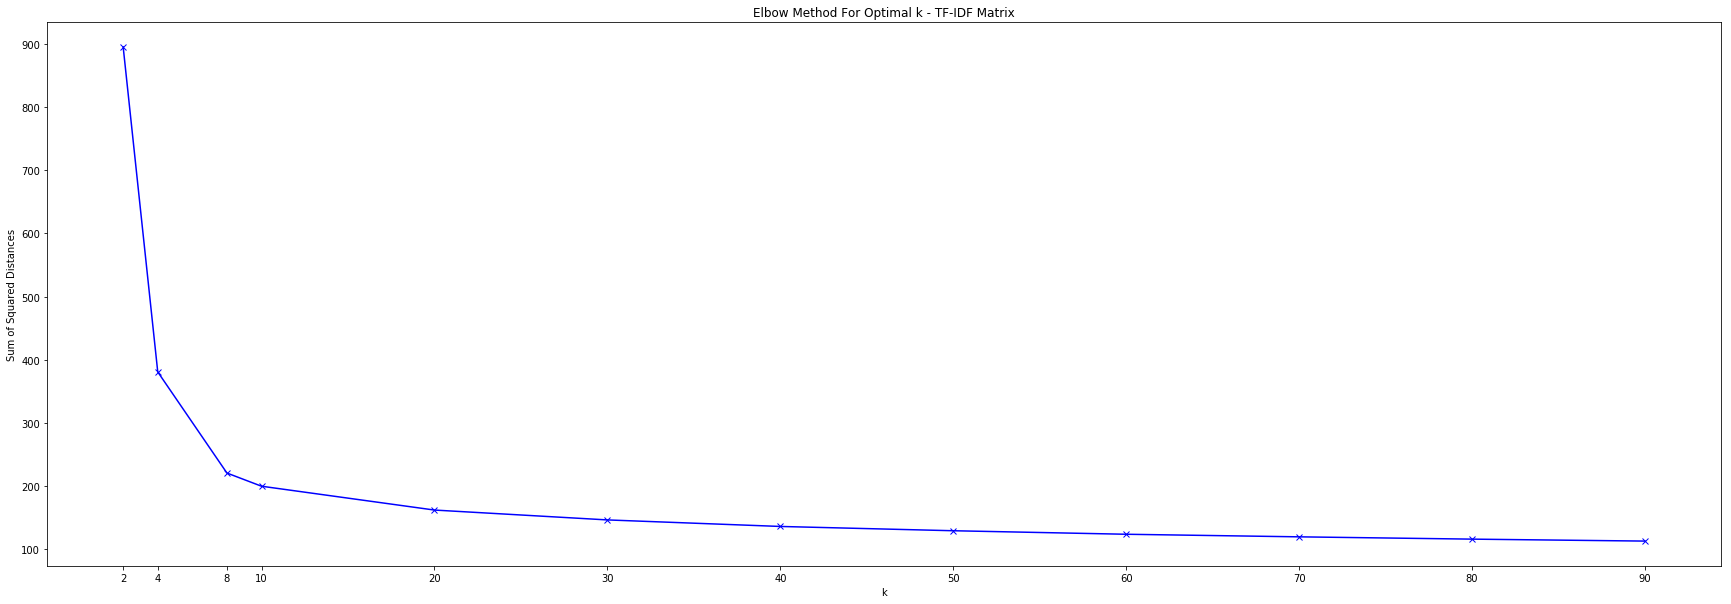

In [43]:
from data_science_toolkit.clustering import find_optimal_num_clusters
# tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, use_idf=True, tokenizer=tokenize_only, ngram_range=(1,5))
# tfidf_matrix = tfidf_vectorizer.fit_transform(stock_tweet["preprocessed_text"].tolist()) #fit the vectorizer to synopses
find_optimal_num_clusters(model.docvecs.doctag_syn0, "TF-IDF Matrix", kmeans)

In [44]:
num_clusters = 8
km, labels, km.inertia_ = kmeans(num_clusters, model.docvecs.doctag_syn0)
# After finding using elbow method...
# joblib.dump(km,  'doc_cluster.pkl')
# km = joblib.load('doc_cluster.pkl')
# clusters = km.labels_.tolist()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  


In [45]:
labels.shape

(11994,)

In [46]:
# order_centroids = km.cluster_centers_.argsort()[:, ::-1]
# for i in range(num_clusters):
#     top_ten_words = [terms[ind] for ind in order_centroids[i, :5]]
#     print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

In [47]:
from sklearn.metrics import pairwise_distances_argmin_min
doc_labels = km.labels_.tolist()
centers = np.array(km.cluster_centers_)
doc_vectors = model.docvecs.doctag_syn0.tolist()
center_distances = [np.linalg.norm(vec-centers[label]) for vec, label in zip(doc_vectors, doc_labels)]
len(center_distances)
#     center_distance = 
# center_distances = list(map(lambda x: np.linalg.norm(centers[]-)))
df = pd.DataFrame({"preprocessed_text": prep_all_tweets, 
                   "cluster": doc_labels, 
                   "vector": doc_vectors, 
                   "center_dist": center_distances})

for i in range(num_clusters):
    tmp = df[df["cluster"] == i]
    tmp = tmp.sort_values(by="center_dist", ascending=True)
    print("Most Common Words (Counter) in Cluster {}".format(i))
    print(Counter(filtered_word_array(' '.join(tmp['preprocessed_text'].tolist()))).most_common(5))
    print("Highest value TF-IDF Words in Cluster {}".format(i))
    vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, tokenizer=tokenize_only)
    X = vectorizer.fit_transform(tmp['preprocessed_text'].tolist())
    indices = np.argsort(vectorizer.idf_)[::-1]
    features = vectorizer.get_feature_names()
    top_n = 10
    top_features = [features[i] for i in indices[:top_n]]
    print(top_features)
    print("Tweets in Cluster {} with Lowest Centroid Distance:".format(i))
    print(tmp.head(10)[["center_dist", 'preprocessed_text']])
    print()
    print()
#     center_vec = centers[i]
#     dist = numpy.linalg.norm(a-b)
# clostest_data = []
# for i in range(num_clusters):
#     center_vec = centers[i]
#     data_idx_within_i_cluster = [ idx for idx, clu_num in enumerate(doc_labels) if clu_num == i ]
# #     print(data_idx_within_i_cluster)
#     one_cluster_tf_matrix = np.zeros( (  len(data_idx_within_i_cluster) , centers.shape[1] ) )
#     for row_num, data_idx in enumerate(data_idx_within_i_cluster):
#         one_row = tf_matrix[data_idx]
#         one_cluster_tf_matrix[row_num] = one_row

#     closest, _ = pairwise_distances_argmin_min(center_vec, one_cluster_tf_matrix)
#     closest_idx_in_one_cluster_tf_matrix = closest[0]
#     closest_data_row_num = data_idx_within_i_cluster[closest_idx_in_one_cluster_tf_matrix]
#     data_id = all_data[closest_data_row_num]

#     closest_data.append(data_id)

# closest_data = list(set(closest_data))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  after removing the cwd from sys.path.


Most Common Words (Counter) in Cluster 0
[('msciurl', 696), ('twitpicture', 587), ('great', 453), ('thank', 371), ('america', 190)]
Highest value TF-IDF Words in Cluster 0
['meetings', 'louisiana', 'successful', 'minnesota', 'system', 'mike', 'team', 'mess', 'yet', 'dnc']
Tweets in Cluster 0 with Lowest Centroid Distance:
       center_dist                              preprocessed_text
3458   0.020259     make america great again !                   
10938  0.023376     keep america great !                         
11265  0.025890     twitpicture                                  
2928   0.026015     thank you !                                  
4834   0.026196     make america great again !                   
10361  0.026696     happy birthday james ! msciurl ...           
7301   0.028504     thank you west virginia ! msciurl twitpicture
1072   0.029336     statement on melania speech msciurl ...      
7666   0.029588     witch hunt !                                 
9898   0.029862 

In [48]:
yikes

NameError: name 'yikes' is not defined

## 3.3 LDA for Topic Clustering - SKIPPING FOR NOW, SINCE IT'S NOT TECHNICALLY PART OF THE REPORT

This section focuses on using Latent Dirichlet Allocation (LDA) to learn yet more about the hidden structure within the top 100 film synopses. LDA is a probabilistic topic model that assumes documents are a mixture of topics and that each word in the document is attributable to the document's topics. There is quite a good high-level overview of probabilistic topic models by one of the big names in the field, David Blei, available in the Communications of the ACM here. Incidentally, Blei was one of the authors of the seminal paper on LDA.
https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

HAD TO ADD THE WORD "GREAT" TO THE STOPWORD LIST BECAUSE IT WAS IN LITERALLY EVERY CLUSTER...

## NOTE THAT EVERY CLUSTERING THING WILL LIKELY HAVE SLIGHTLY DIFFERENT PREPROCESSING PARAMS!!!

In [49]:
# Remove proper nouns (in this case get rid of all mentions)
# TRUMP ==============================================================================================================
stock_tweet['preprocessed_no_mentions'] = stock_tweet['preprocessed_text'].apply(lambda tweet: ' '.join([w for w in tweet.split(' ') 
                                                                                                               if w not in stop_words.union({'msciurl', 'twitpicture', 'great'}) 
                                                                                                               and re.search('[a-zA-Z]', w)]))

# ELON MUSK ===========================================================================================================
# Remove proper nouns (in this case get rid of all mentions)
# stock_tweet['preprocessed_no_mentions'] = stock_tweet['preprocessed_text'].apply(lambda tweet: ' '.join([w for w in tweet.split(' ') 
#                                                                                                                if w not in stop_words.union({'msciurl', 'twitpicture', "'s'"}) 
#                                                                                                                and re.search('[a-zA-Z]', w)]))

In [50]:
texts = [[ting for ting in x.split(" ") if ting != ''] for x in stock_tweet['preprocessed_no_mentions'].tolist()]
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.3)
# 0.21

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

In [51]:
coherence_scores = []
for i in range(2, 50, 2):
    lda = models.LdaMulticore(corpus, num_topics=i, 
                                id2word=dictionary, iterations=500)
    coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_lda)

In [52]:
# coherence_scores

Text(0.5, 0, 'Num Topics')

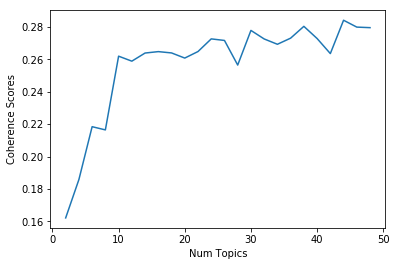

In [53]:
plt.plot([x for x in range(2, 50, 2)], coherence_scores)
plt.ylabel("Coherence Scores")
plt.xlabel("Num Topics")

In [54]:
lda_num_topics = 12

In [55]:
lda = models.LdaMulticore(corpus, num_topics=lda_num_topics, iterations=500,
                                id2word=dictionary)

In [56]:
lda.show_topics(num_topics=lda_num_topics)

[(0,
  '0.009*"thank" + 0.009*"people" + 0.007*"want" + 0.007*"democrats" + 0.006*"country" + 0.006*"border" + 0.005*"mexico" + 0.005*"u.s." + 0.005*"many" + 0.005*"get"'),
 (1,
  '0.011*"people" + 0.007*"president" + 0.007*"time" + 0.007*"bad" + 0.006*"get" + 0.006*"democrats" + 0.005*"back" + 0.005*"news" + 0.005*"trump" + 0.005*"many"'),
 (2,
  '0.007*"big" + 0.007*"country" + 0.007*"people" + 0.006*"president" + 0.006*"never" + 0.006*"democrats" + 0.006*"thank" + 0.005*"fake" + 0.005*"news" + 0.005*"media"'),
 (3,
  '0.007*"people" + 0.007*"thank" + 0.007*"trump" + 0.007*"many" + 0.007*"america" + 0.006*"president" + 0.006*"get" + 0.005*"country" + 0.005*"news" + 0.005*"china"'),
 (4,
  '0.008*"thank" + 0.005*"president" + 0.005*"never" + 0.005*"news" + 0.005*"much" + 0.005*"trump" + 0.005*"hillary" + 0.005*"fake" + 0.004*"border" + 0.004*"n\'t"'),
 (5,
  '0.009*"big" + 0.008*"president" + 0.008*"people" + 0.006*"fake" + 0.006*"news" + 0.006*"much" + 0.005*"new" + 0.005*"trump" + 0

- The area of circle represents the importance of each topic over the entire corpus
- The distance between the center of circles indicate the similarity between topics.
- Indices = sorted order by area
- Blue = overall term frequency
- Red = term freq within selected topic
- Lambda: trying to strike a balance between choosing general vs specific words (lambda=0 means super specific - exclusively popular for this topic)
- If some topics contain general words/feelings/sentiments

In [57]:
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [58]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# df_dominant_topic.head(10)
df_dominant_topic['preprocessed_text'] = prep_all_tweets

In [59]:
# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda.show_topics(num_topics=lda_num_topics, formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

# print(lda.show_topics(num_topics=lda_num_topics, formatted=False))

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(' '.join)
df_top3words.reset_index(level=0,inplace=True)
df_top3words

,topic_id,words
0,0,thank people want
1,1,people president time
2,2,big country people
3,3,people thank trump
4,4,thank president never
5,5,big president people
6,6,country new thank
7,7,thank hillary news
8,8,people thank trump
9,9,border people democrats


In [60]:
df = None
sample_size=5
for i in range(lda_num_topics):
    curr_cluster = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == i].sort_values(by='Topic_Perc_Contrib', ascending=False)
    if df is None:
        df = curr_cluster.head(sample_size)#.sample(n=min(sample_size, len(curr_cluster.index)-1))
    else:
        df = df.append(curr_cluster.head(sample_size))#curr_cluster.sample(n=min(sample_size, len(curr_cluster.index)-1)))
    df = df.append(pd.Series(), ignore_index=True)
df[["preprocessed_text", "Dominant_Topic", 'Topic_Perc_Contrib']]

,preprocessed_text,Dominant_Topic,Topic_Perc_Contrib
0,"democrat uaw local 1112 president david green ought to get his act together and produce . g.m . let our country down , but other much better car companies are coming into the u.s. in droves . i want action on lordstown fast . stop complaining and get the job done ! 3.8 % unemployment !",0.0,0.9713
1,"despite so many positive events and victories , media reseach center reports that 92 % of stories on donald trump are negative on abc , cbs and abc . it is fake news ! don ' t worry , the failing new york times didn ' t even put the brett kavanaugh victory on the front page yesterday-a17 !",0.0,0.9713
2,".twitmentiondaveweigel twitmentionwashingtonpost put out a phony photo of an empty arena hours before i arrived @ the venue , w/ thousands of people outside , on their way in . real photos now shown as i spoke . packed house , many people unable to get in . demand apology & retraction from fake news wapo ! twitpicture",0.0,0.9713
3,so many people at the higher ends of intelligence loved my press conference performance in helsinki . putin and i discussed many important subjects at our earlier meeting . we got along well which truly bothered many haters who wanted to see a boxing match . big results will come !,0.0,0.9713
4,"senator schumer and obama administration let phone company zte flourish with no security checks . i closed it down then let it reopen with high level security guarantees , change of management and board , must purchase u.s. parts and pay a $ 1.3 billion fine . dems do nothing ... .",0.0,0.9704
5,NaN,NaN,NaN
6,"the fake news gets crazier and more dishonest every single day . amazing to watch as certain people covering me , and the tremendous success of this administration , have truly gone mad ! their fake reporting creates anger and disunity . take two weeks off and come back rested . chill !",1.0,0.9713
7,"... ..this was done by the democrats in order to make me look as bad as possible when i was successfully raising billions of dollars to help rebuild puerto rico . if a person died for any reason , like old age , just add them onto the list . bad politics . i love puerto rico !",1.0,0.9704
8,"the fake news media has lost tremendous credibility with its corrupt coverage of the illegal democrat witch hunt of your all time favorite duly elected president , me ! t.v . ratings of cnn & msnbc tanked last night after seeing the mueller report statement . twitmentionfoxnews up big !",1.0,0.9704
9,"i feel very badly for paul manafort and his wonderful family . "" justice "" took a 12 year old tax case , among other things , applied tremendous pressure on him and , unlike michael cohen , he refused to "" break "" - make up stories in order to get a "" deal. "" such respect for a brave man !",1.0,0.9704


# SAVE DATA (COMMENTED OUT)

In [61]:
# lda.save('44_clusters_removed_great_lda.model')
# df.to_csv('lda_44_clusters_removed_great.csv', index=False)

# LDA VISUALIZATION (COMMENTED OUT)

In [62]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary=lda.id2word)
vis

# 4.0 Distributions

## 4.1.1 Time of Day (Up vs Down)

Exception in get_axis 'AxesSubplot' object has no attribute 'any'
Exception in get_axis 'AxesSubplot' object has no attribute 'any'


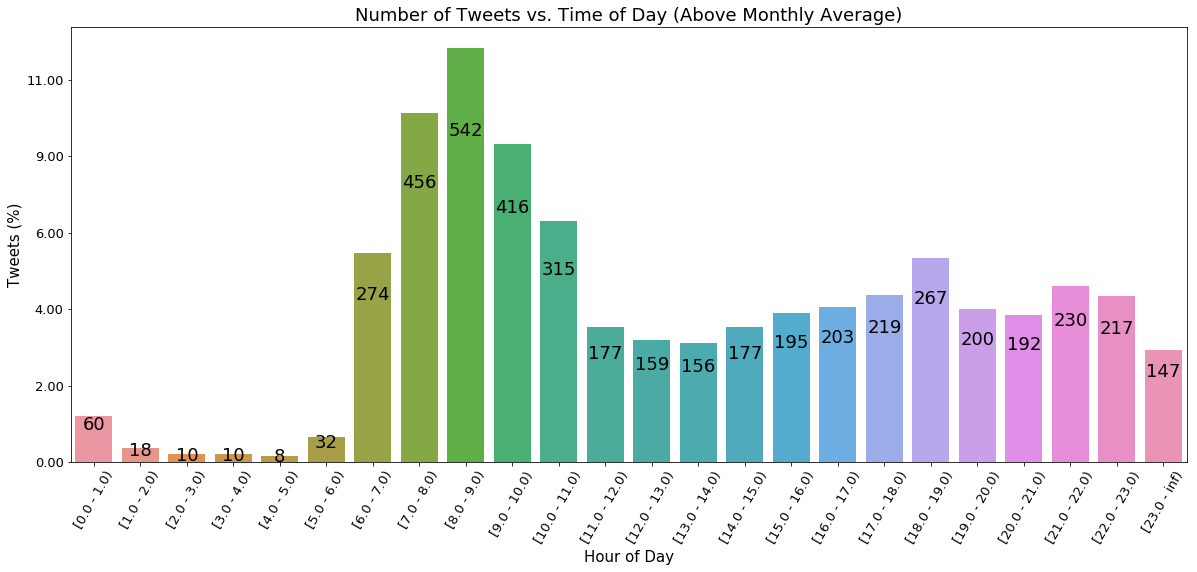

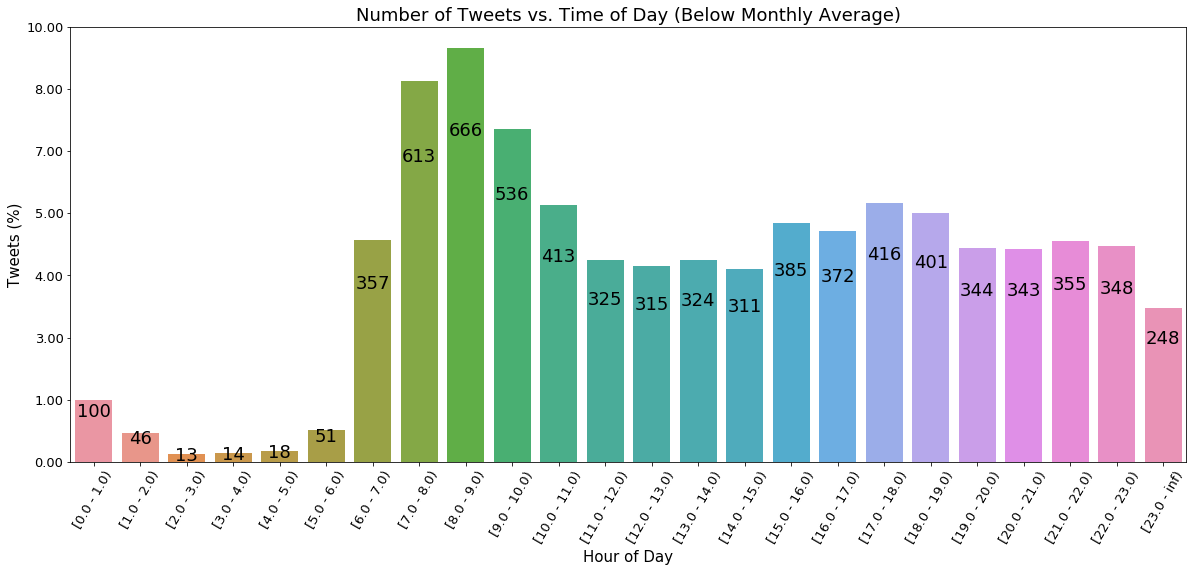

In [63]:
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["created_hour"], ax, 0, 0, "Hour of Day", "Tweets (%)", 
                        "Number of Tweets vs. Time of Day (Above Monthly Average)", True, show_mean=False, show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["created_hour"], ax, 0, 0, "Hour of Day", "Tweets (%)", 
                        "Number of Tweets vs. Time of Day (Below Monthly Average)", True, show_mean=False, show_sd=False, show_best_fit=False)

## 4.2.1 Day of Week (Up vs Down)

Exception in get_axis 'AxesSubplot' object has no attribute 'any'
Exception in get_axis 'AxesSubplot' object has no attribute 'any'


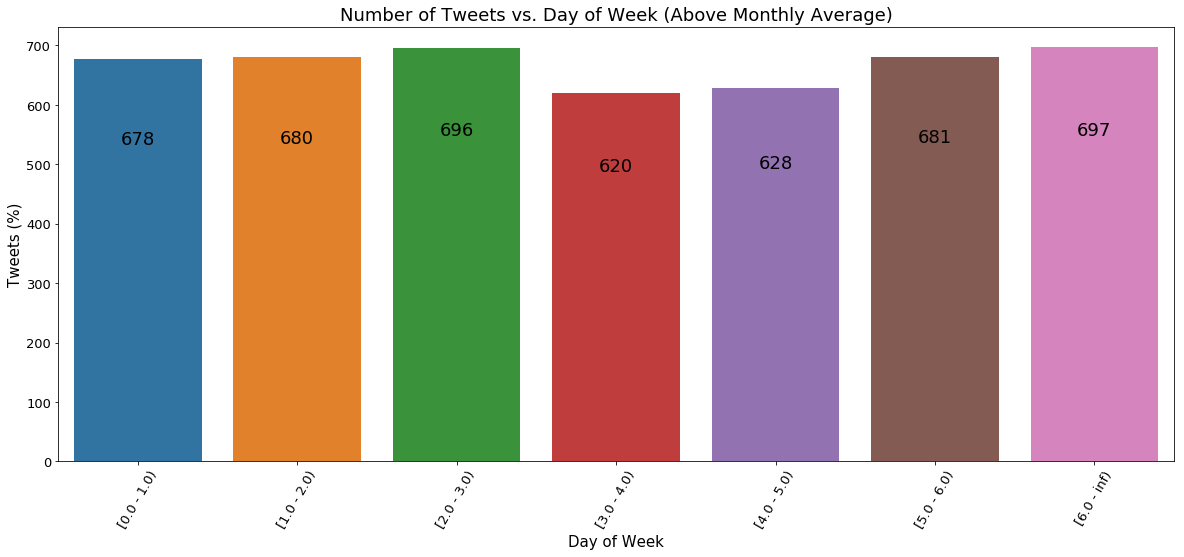

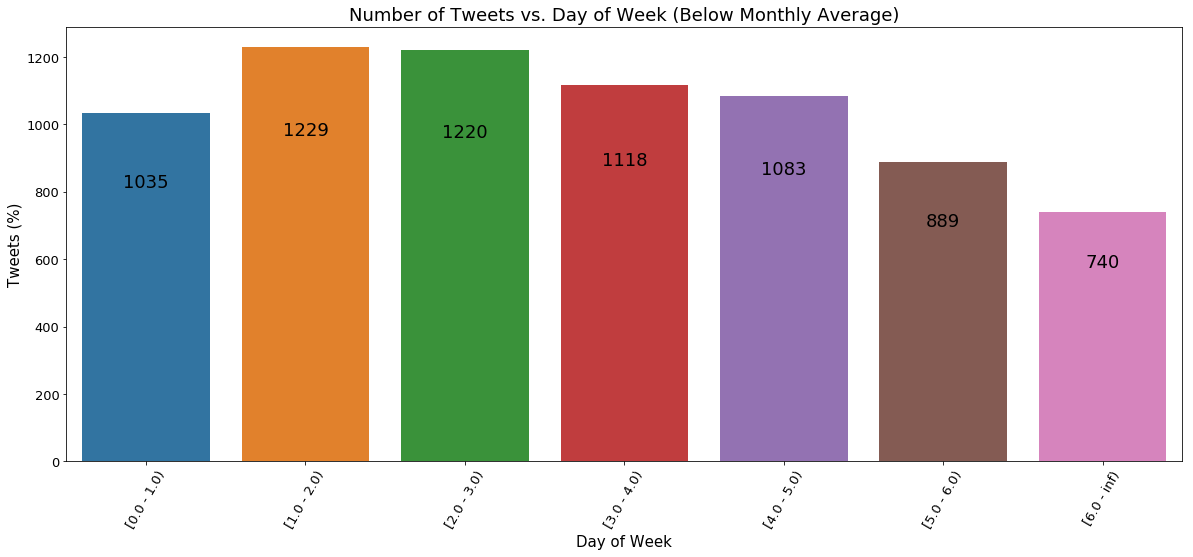

In [64]:
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["dow"], ax, 0, 0, "Day of Week", "Tweets (%)", 
                        "Number of Tweets vs. Day of Week (Above Monthly Average)", False, show_mean=False, show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["dow"], ax, 0, 0, "Day of Week", "Tweets (%)", 
                        "Number of Tweets vs. Day of Week (Below Monthly Average)", False, show_mean=False, show_sd=False, show_best_fit=False)

## 4.3 Num Retweets over Time

In [65]:
from data_science_toolkit.file_ops import read_pkl
dt_avg = read_pkl("dt_avg_{}.pkl".format(file_name))

In [66]:
avg_retweets, dates = [], []
for year in dt_avg:
    for month in dt_avg[year]:
        avg_retweets.append(dt_avg[year][month])
        dates.append(datetime(year, month, 1))
dates, avg_retweets = list(zip(*sorted(list(zip(dates, avg_retweets)), key=lambda x: x[0])))

# Average Number of Retweets per Month
- The average number of retweets Trump gets per month varies significantly, and also jumped during the middle of the year (around when he got elected)
- This makes comparing to a monthly average more appropriate

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


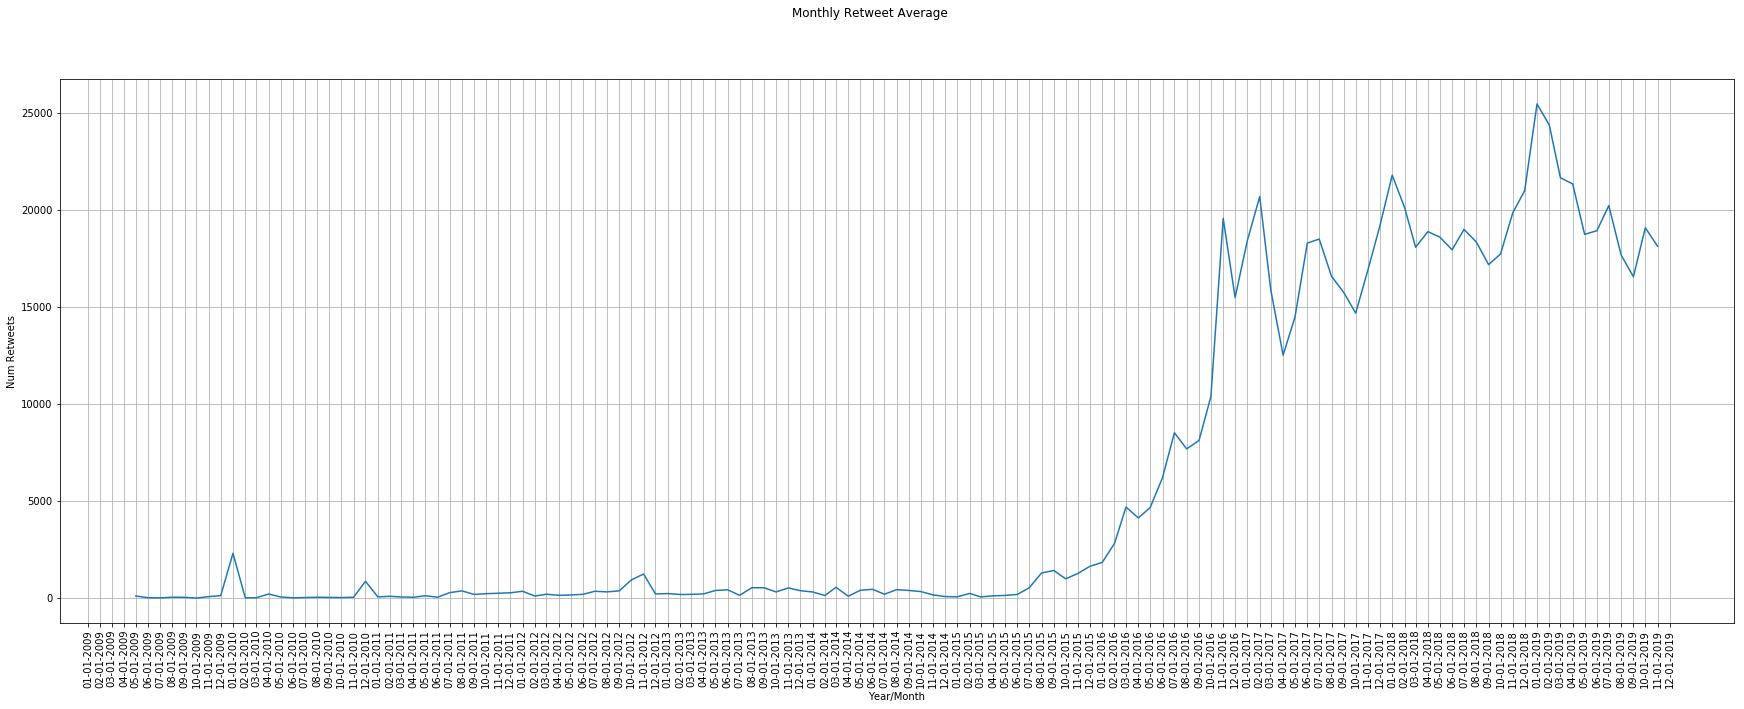

In [67]:
fig = plt.figure(figsize=(30, 10))
plt.plot(dates, avg_retweets)
fig.suptitle('Monthly Retweet Average')
plt.xlabel('Year/Month')
plt.ylabel('Num Retweets')
plt.xticks(dates, [x.strftime('%m-%d-%Y') for x in dates], rotation=90)
plt.grid(True)
plt.show()

## 5.1 Tweet Anatomy

Exception in get_axis 'AxesSubplot' object has no attribute 'any'
Exception in get_axis 'AxesSubplot' object has no attribute 'any'


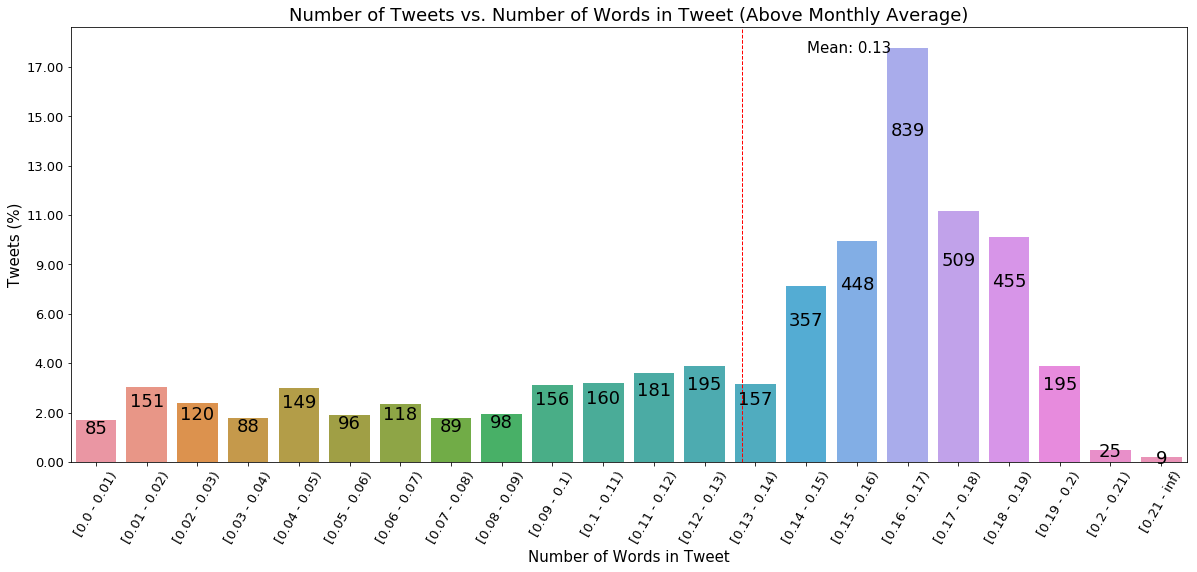

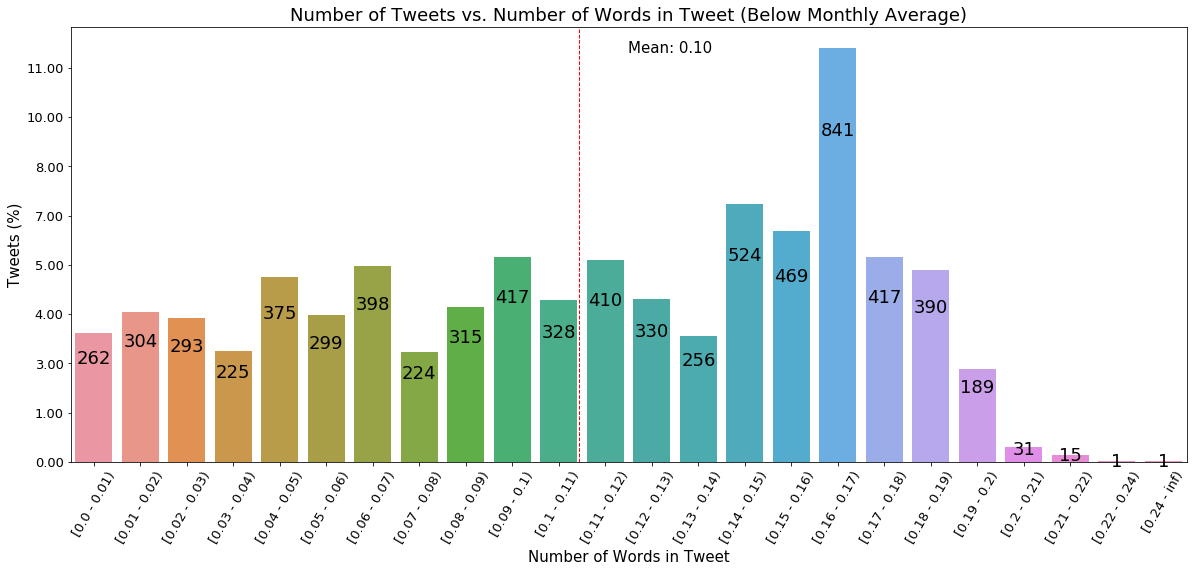

In [68]:
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_words"], ax, 0, 0, 
                        "Number of Words in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Words in Tweet (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_words"], ax, 0, 0, 
                        "Number of Words in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Words in Tweet (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

In [69]:
# stock_tweet[since_election.num_words > 55]

In [70]:
set(stock_tweet[stock_tweet[output_col] == 0]['num_links'].tolist())

{0, 1}

Exception in get_axis 'AxesSubplot' object has no attribute 'any'
Exception in get_axis 'AxesSubplot' object has no attribute 'any'


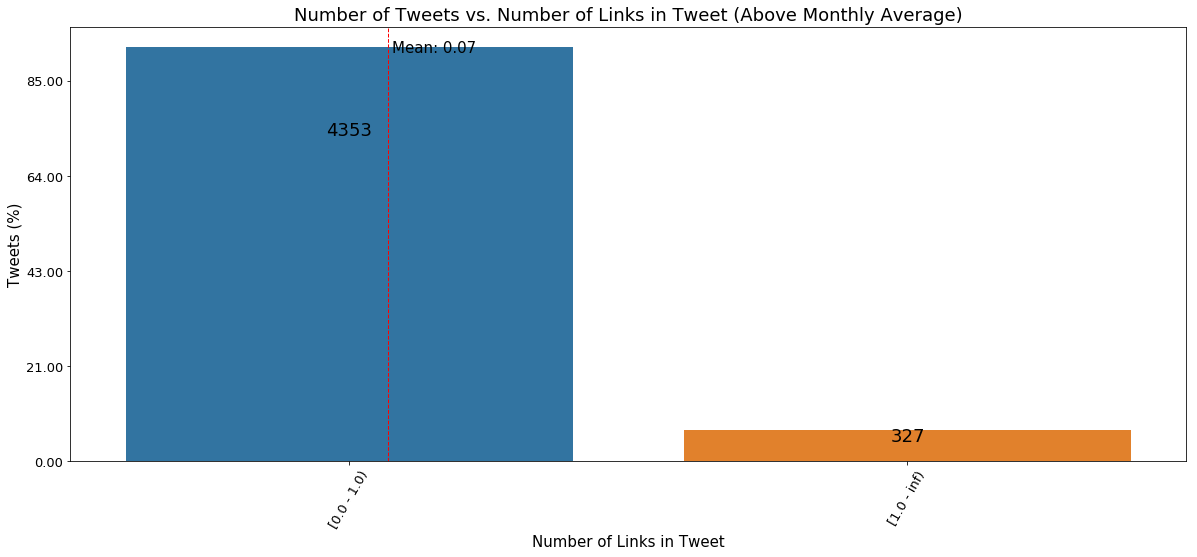

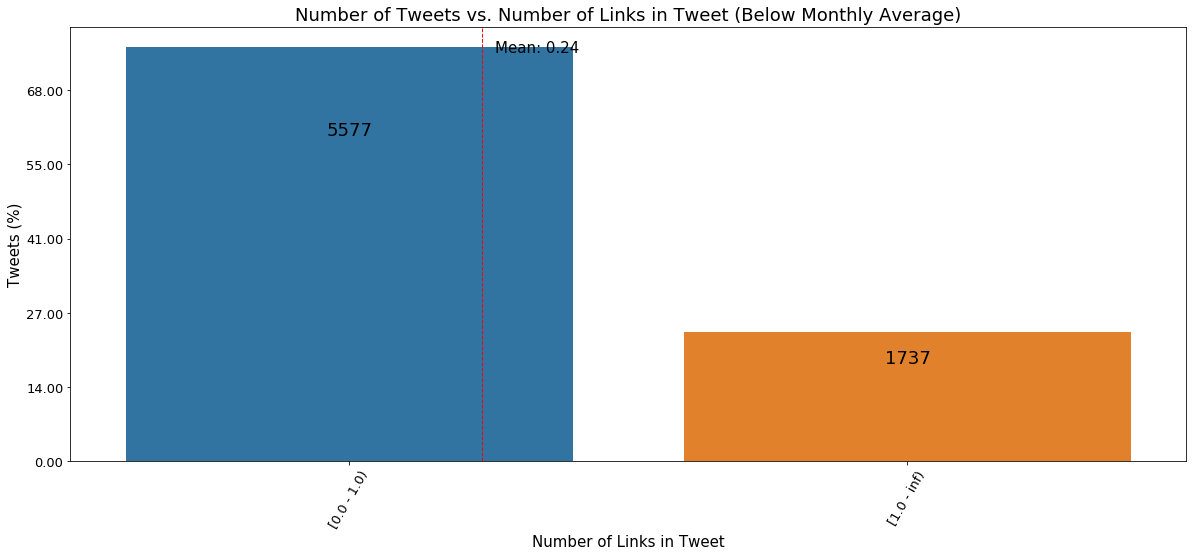

In [71]:
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_links"], ax, 0, 0, 
                        "Number of Links in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Links in Tweet (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_links"], ax, 0, 0, 
                        "Number of Links in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Links in Tweet (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

Exception in get_axis 'AxesSubplot' object has no attribute 'any'
Exception in get_axis 'AxesSubplot' object has no attribute 'any'


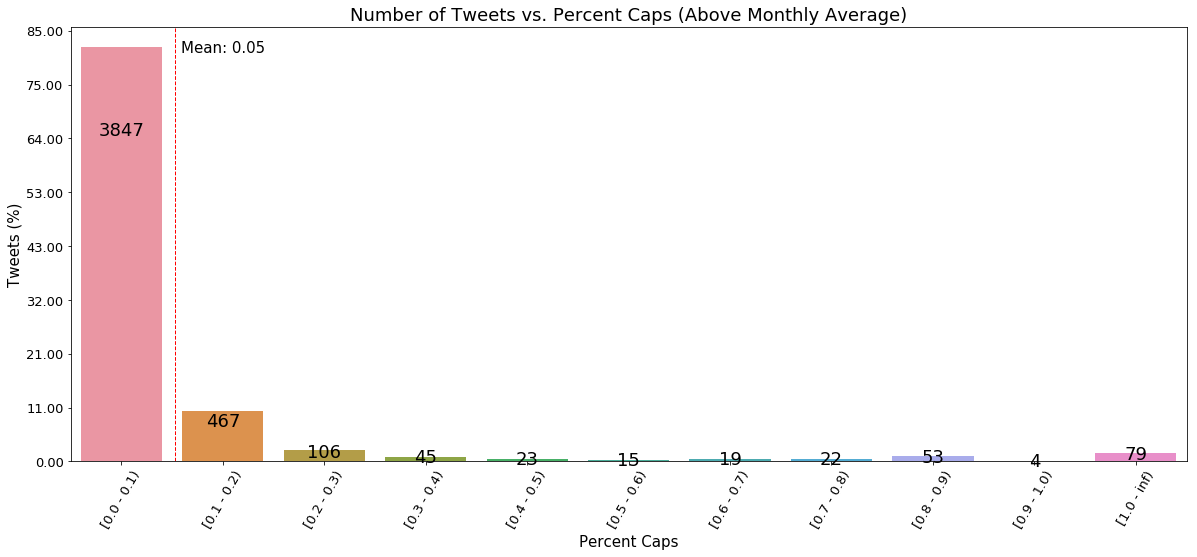

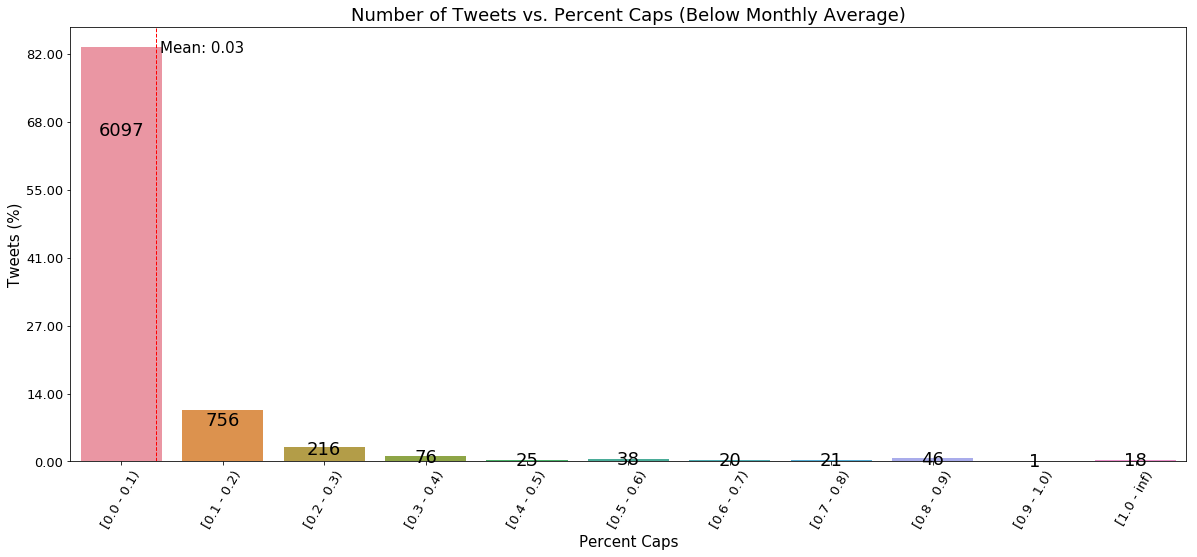

In [72]:
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["percent_caps"], ax, 0, 0, 
                        "Percent Caps", "Tweets (%)", "Number of Tweets vs. Percent Caps (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["percent_caps"], ax, 0, 0, 
                        "Percent Caps", "Tweets (%)", "Number of Tweets vs. Percent Caps (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

Exception in get_axis 'AxesSubplot' object has no attribute 'any'
Exception in get_axis 'AxesSubplot' object has no attribute 'any'


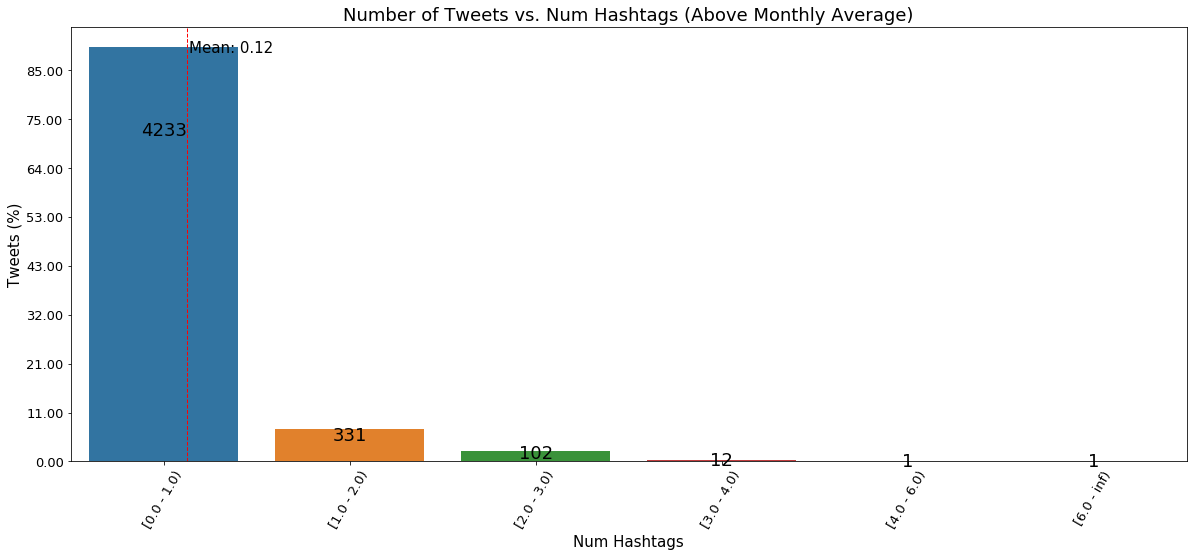

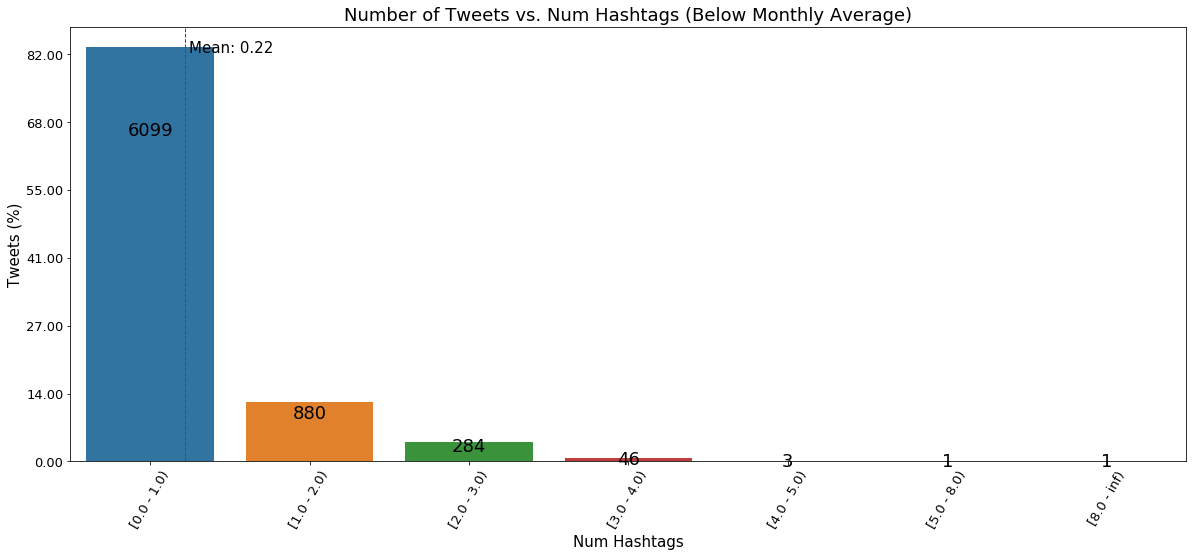

In [73]:
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_hashtags"], ax, 0, 0, 
                        "Num Hashtags", "Tweets (%)", "Number of Tweets vs. Num Hashtags (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_hashtags"], ax, 0, 0, 
                        "Num Hashtags", "Tweets (%)", "Number of Tweets vs. Num Hashtags (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

Exception in get_axis 'AxesSubplot' object has no attribute 'any'
Exception in get_axis 'AxesSubplot' object has no attribute 'any'


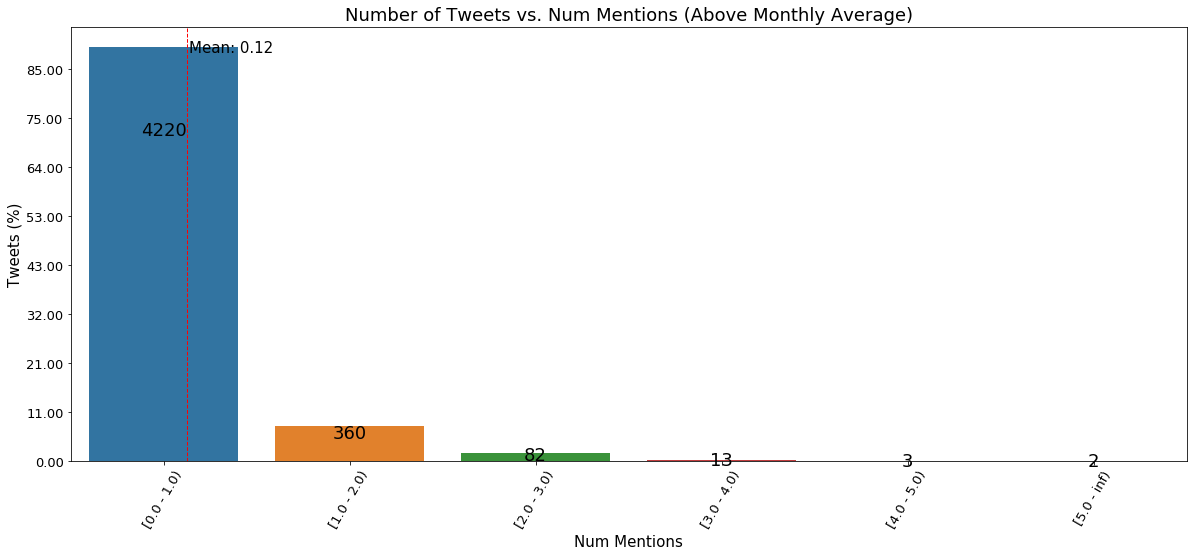

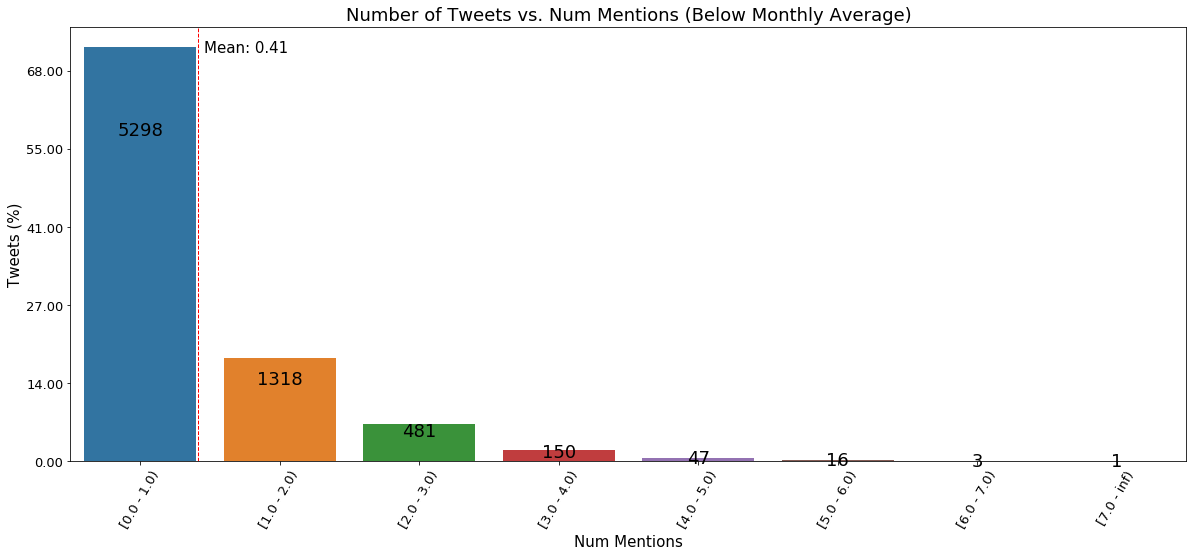

In [74]:
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_mentions"], ax, 0, 0, 
                        "Num Mentions", "Tweets (%)", "Number of Tweets vs. Num Mentions (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_mentions"], ax, 0, 0, 
                        "Num Mentions", "Tweets (%)", "Number of Tweets vs. Num Mentions (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

Exception in get_axis 'AxesSubplot' object has no attribute 'any'
Exception in get_axis 'AxesSubplot' object has no attribute 'any'


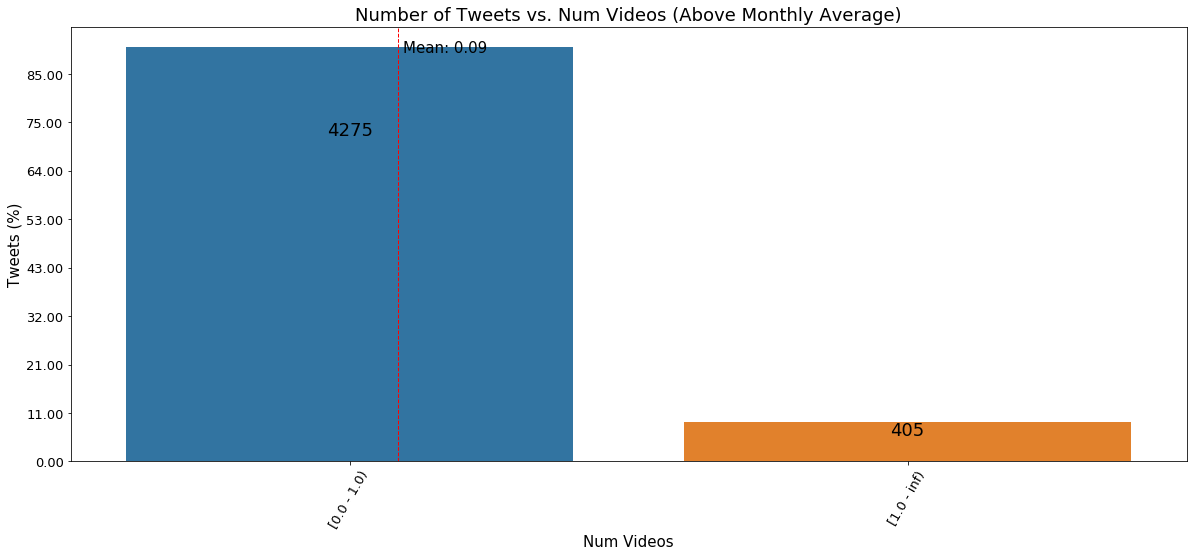

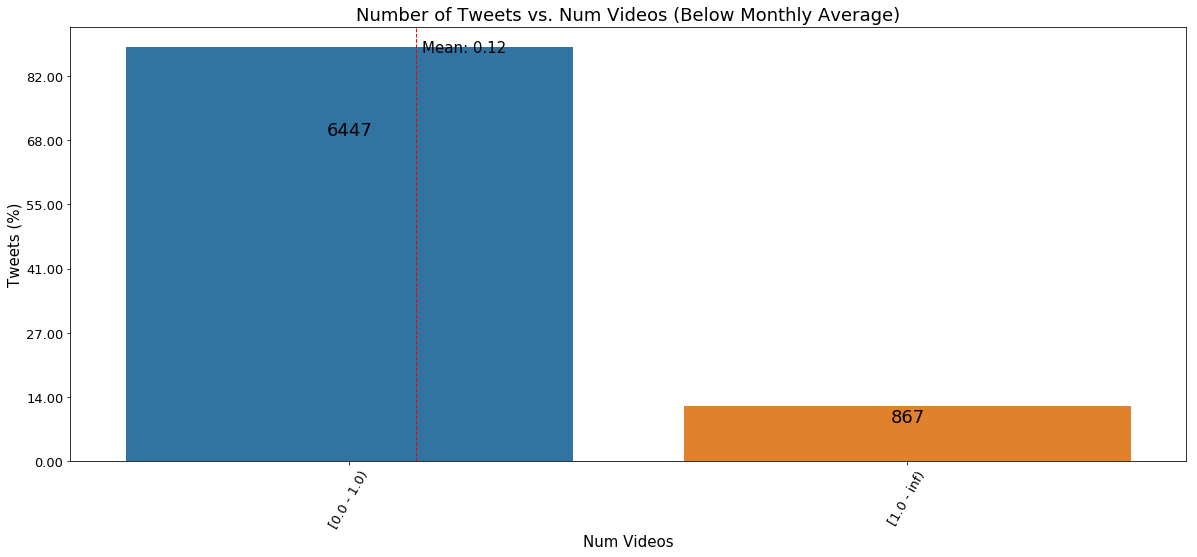

In [75]:
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_videos"], ax, 0, 0, 
                        "Num Videos", "Tweets (%)", "Number of Tweets vs. Num Videos (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_videos"], ax, 0, 0, 
                        "Num Videos", "Tweets (%)", "Number of Tweets vs. Num Videos (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

Exception in get_axis 'AxesSubplot' object has no attribute 'any'
Exception in get_axis 'AxesSubplot' object has no attribute 'any'


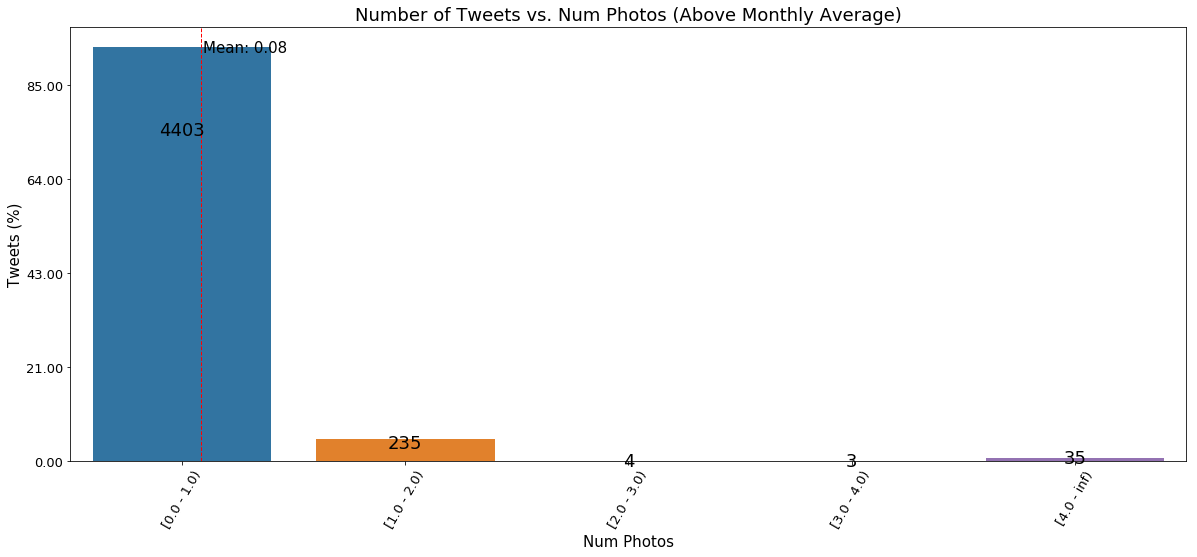

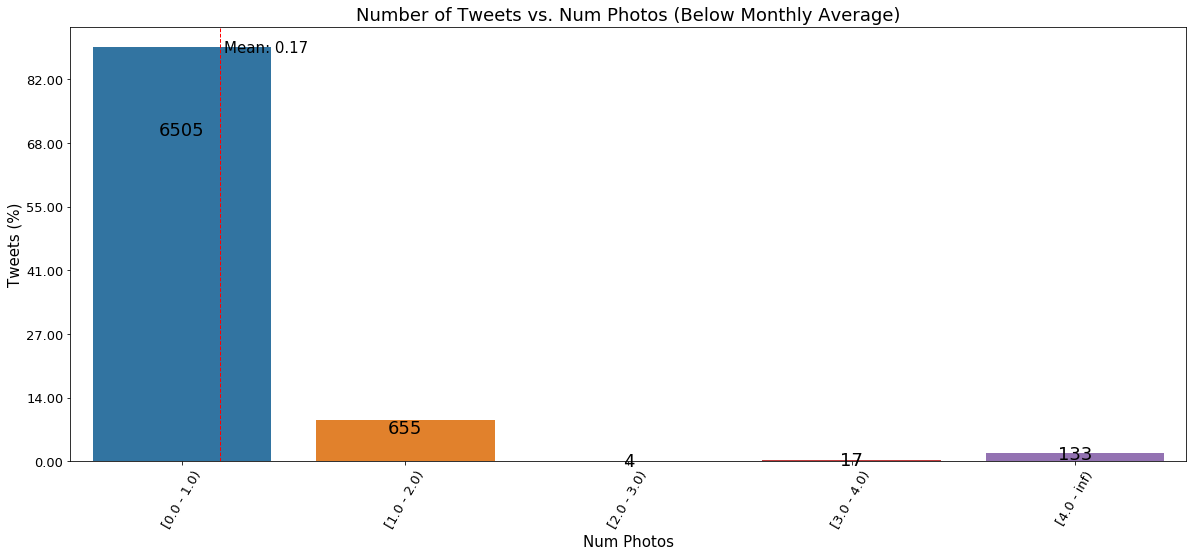

In [76]:
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_photos"], ax, 0, 0, 
                        "Num Photos", "Tweets (%)", "Number of Tweets vs. Num Photos (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_photos"], ax, 0, 0, 
                        "Num Photos", "Tweets (%)", "Number of Tweets vs. Num Photos (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

In [77]:
# stock_tweet.head(10)

In [78]:
# since_election.head(10)

## This is what we will be using for models...

In [79]:
stock_tweet.to_csv('./since_election_with_cluster_{}'.format(file_name), index=False)